# Create Dataset

In [21]:
from PIL import Image
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import pickle
import sat_utils
import tifffile as tiff
import os
import natsort as ns

folder_path='./data/images'

input: (8, 650, 650)
input2: (650, 650, 8)
target: (3, 650, 650)


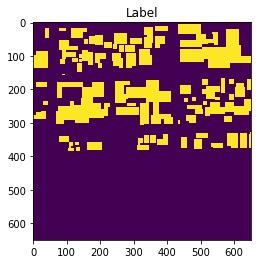

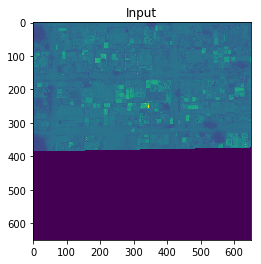

input: (8, 650, 650)
target: (3, 650, 650)


In [22]:
target = sat_utils.load_map_tiff('MUL-PanSharpen_AOI_5_Khartoum_img16_target.tif')
input = sat_utils.load_map_tiff('MUL-PanSharpen_AOI_5_Khartoum_img16_input.tif')

# Open same image with channels inverted
input2 = tiff.imread('MUL-PanSharpen_AOI_5_Khartoum_img16_input.tif').astype(np.float32)

print('input:', input.shape)
print('input2:', input2.shape)
print('target:', target.shape)

plt.imshow(target[0,:,:])
plt.title('Label');
plt.show()

plt.imshow(input[4,:,:])
plt.title('Input');
plt.show()

print('input:', input.shape)
print('target:', target.shape)

#### Crop and Display

In [ ]:
crop_target = sat_utils.crop_img(target,0,0,76,76)
print('Original:',target.shape)
print('Cropped:',crop_target.shape)
print('Max target:', np.max(target))
print('Min target:', np.min(target))
plt.imshow(crop_target[0,:,:])
plt.show()

#crop_input = utils.crop_img(input,0,0,76,76)
#crop_input = utils.get_rgb(input2)

#rgb = utils.get_rgb(input2, channelsFirst=False)
#rgb = np.dstack((input2[:, :, 4], input2[:, :, 2], input2[:, :, 1]))

crop_input2 = sat_utils.crop_img(input2,0,0,76,76, channelsFirst=False)
rgb2 = sat_utils.get_rgb(crop_input2, channelsFirst=False)
rgb_norm2 = sat_utils.img_minmax_norm(rgb2, channelsFirst=False)
plt.imshow( rgb_norm2 )
plt.show()

crop_input1 = sat_utils.crop_img(input,0,0,76,76, channelsFirst=True)
rgb1 = sat_utils.get_rgb(crop_input1, channelsFirst=True)
rgb_norm1 = sat_utils.img_minmax_norm(rgb1, channelsFirst=True)
rgb_norm1 = np.moveaxis(rgb_norm1, 0, 2)
plt.imshow( rgb_norm1 )
plt.show()
print('Original:',input.shape)
print('Cropped:',crop_input1.shape)

In [ ]:
dict_input, dict_output = sat_utils.crop_blocks(input, target, display=True, earlyStop=39)

#### Get List of files

In [23]:
input_paths_dict={}
target_paths_dict={}
for root, dirs, files in os.walk(folder_path):
        files = ns.natsorted(files)
        for file in files[0::]:
            img_path = os.path.join(root, file)
            parts = os.path.splitext(file)[0].split('_')
            img_id = parts[-2]
                       
            if parts[-1]=="input":
                input_paths_dict[img_id] = img_path
            if parts[-1]=="target":
                target_paths_dict[img_id] = img_path

#### Populate Dictionaries

In [24]:
all_input_dict={}
all_target_dct={}
count=0
for key, value in input_paths_dict.items():
    
    input = sat_utils.load_map_tiff(value)
    target = sat_utils.load_map_tiff(target_paths_dict[key])
    
    dict_input, dict_output = sat_utils.crop_blocks(input, target, display=False, earlyStop=39, offset=count*39)
    all_input_dict.update(dict_input)
    all_target_dct.update(dict_output)
    print('Elements added:', len(all_input_dict))
    count+=1

Elements added: 40
Elements added: 79
Elements added: 118
Elements added: 157
Elements added: 196
Elements added: 235
Elements added: 274
Elements added: 313
Elements added: 352
Elements added: 391
Elements added: 430


#### Clean dataset

In [25]:
all_input_dict, all_target_dct = sat_utils.clean_data(all_input_dict, all_target_dct)
print('New number of elements:', len(all_target_dct))

New number of elements: 256


#### Save dictionaries to pickle

In [26]:
with open('./data/input.pickle', 'wb') as handle:
    pickle.dump(all_input_dict, handle)

with open('./data/label.pickle', 'wb') as handle:
    pickle.dump(all_target_dct, handle)